In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.utils import check_random_state

from collections import OrderedDict
from functools import partial
from time import time
from sklearn import manifold
import collections

from toy_data import Swiss_roll


## Make Swiss Roll data

We make a 3D swiss-roll with intrinsic dimension 2, where we add gaussian noises to the three axes, and 10 additional dimensions of noises.

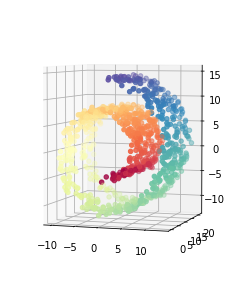

In [5]:
seed = 1033
n_samples = 1000
sigma_primary = 0.3
additional_dims = 10
# sigma_additional = 0.1

swiss_roll = Swiss_roll(n_samples, seed=seed, with_hole=True)

X, _, color = swiss_roll.gen(sigma_primary = sigma_primary, additional_dims=additional_dims)
swiss_roll.plot(X, color)

## Scikit-Learn `Manifold` Package

In [6]:
n_neighbors = 10
n_components = 2

# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, neighbors_algorithm='ball_tree', eigen_solver='auto')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
methods['Hessian LLE'] = LLE(method='hessian')
# methods['Modified LLE'] = LLE(method='modified')
# methods['embedding'] = SpectralEmbedding(n_components, n_neighbors) 
methods['embedding'] = manifold.SpectralEmbedding(n_components, affinity='rbf', gamma=1)
# unable to use the rbf-kernel to construct affinity matrix for spectral embedding
methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
# methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
# methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
#                                            n_neighbors=n_neighbors)
# methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
#                                  random_state=0)

LLE: 0.19 sec
LTSA: 0.23 sec
Hessian LLE: 0.37 sec
embedding: 0.71 sec
Isomap: 0.38 sec


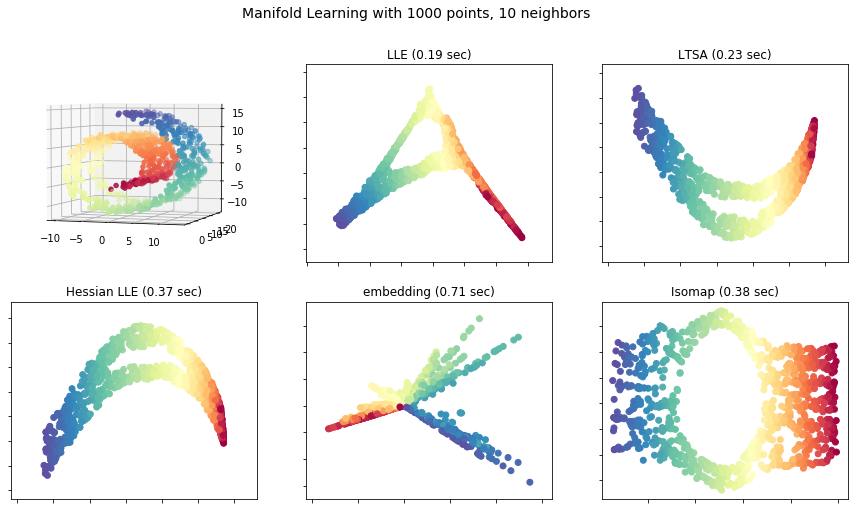

In [7]:
# Plot results
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

# Add 3d scatter plot
ax = fig.add_subplot(231, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 3, 2+i)
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
plt.show()

The implementation only concerns the discrete KNN in stead of r-NN with rbf Kernel for example. Even though the `SpectralEmbedding` method has this argument in its doc, the 0.19 version does not have it. It is highly sensitive to the kernel lengthscale chosen. And the performance is not the same to that of Megaman's.

## `Megaman` Package 

First initialise the geometry object, and compute the adjacency matrix, then the affinity matrix and finally graph Laplacian. This object will be used to compute the embedding of the data with different NLDR methods.

In [8]:
from megaman.geometry import Geometry
from scipy.sparse.csgraph import connected_components
from megaman.embedding import (Isomap, LocallyLinearEmbedding,
                               LTSA, SpectralEmbedding)


In [9]:
geom = Geometry()
geom.set_data_matrix(X)

In [10]:
rad1 = 3
# compute an adjacency matrix with a radius
geom.adjacency_kwds = {'radius':rad1}
adjacency_matrix = geom.compute_adjacency_matrix()

# compute the corresponding affinity matrix
geom.affinity_kwds = {'radius':rad1}
affinity_matrix = geom.compute_affinity_matrix({'radius':rad1})
(number_connected_components, labels) = connected_components(affinity_matrix)
print(number_connected_components)

1


In [11]:
radius = 3
methods = OrderedDict()
geom.adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kmeans', 'branching':64, 'iterations':20, 'cb_index':0.4}
# cyflann_kwds = {'index_type':'kdtrees', 'num_trees':10}
geom.adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
# geom.adjacency_method = 'auto'
# geom.adjacency_kwds = {'radius':radius}

geom.affinity_method = 'gaussian'
geom.affinity_kwds = {'radius':radius}

geom.laplacian_method = 'symmetricnormalized'
geom.laplacian_kwds = {'scaling_epps':radius}
# n_components = 2

methods['spectral'] = SpectralEmbedding(n_components=2, eigen_solver='amg',geom=geom, drop_first=True) 
methods['ltsa'] = LTSA(n_components=2, eigen_solver='arpack', geom=geom)
methods['lle'] = LocallyLinearEmbedding(n_components=2, eigen_solver='arpack',geom=geom)
methods['isomap'] = Isomap(n_components=2, eigen_solver='arpack',geom=geom)


/Users/xuyidan/miniconda3/envs/yourenvname/lib/python3.5/site-packages/sklearn/utils/validation.py:393: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)
spectral: 0.26 sec
/Users/xuyidan/miniconda3/envs/yourenvname/lib/python3.5/site-packages/sklearn/utils/validation.py:393: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)
ltsa: 1.7 sec
/Users/xuyidan/miniconda3/envs/yourenvname/lib/python3.5/site-packages/sklearn/utils/validation.py:393: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instea

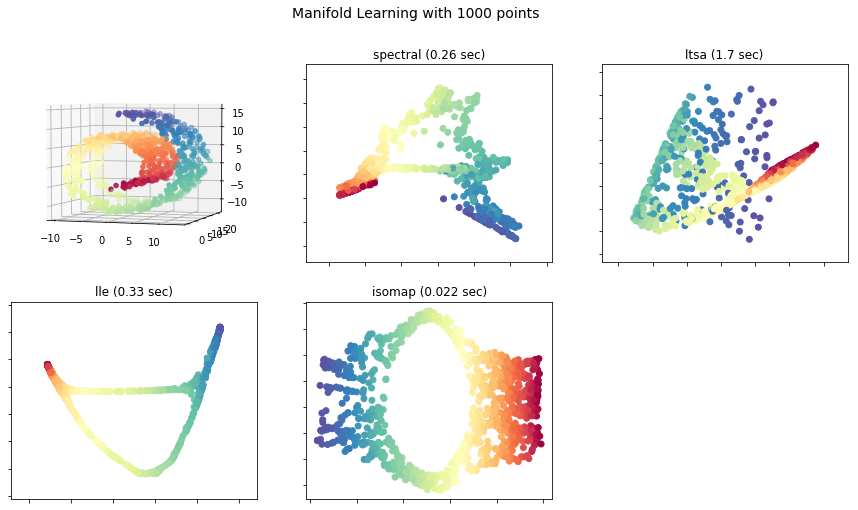

In [15]:
# Plot results
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Manifold Learning with %i points"
             % n_samples, fontsize=14)

# Add 3d scatter plot
ax = fig.add_subplot(231, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 3, 2+i)
    # if Y.shape[1] is 3:
    #     ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=color, cmap=plt.cm.Spectral)
    # else:
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.set_title("%s (%.2g sec)"  % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
plt.show()

The ARPACK is not working well for radius that produces many connected components, used auto instead; trying with various radius but the performance of LTSA is not good, the first two projected dim is always looking 3D (different to the sklearn implementation).
Moreover, it seems that we are not able to cast the data to higher dims in embedding space other than 2 (something wrong with the code?)

`Gi[:, 1:] = v[:, :n_components]`
`ValueError: could not broadcast input array from shape (2,2) into shape (2,3)`


Spectral method and LLE performs consistantly bad, similar to LTSA. Isomap, on the other hand, gives okay performance, in terms of being able to recover 2D manifold.